/tmp/ipykernel_115829/2587006485.py:100: RuntimeWarning: invalid value encountered in log
  bt67=planck_c2/(6.72*np.log(planck_c1/(emis67*6.72**5.0)+1))
/data/keeling/a/yulanh/anaconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/data/keeling/a/yulanh/anaconda3/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/data/keeling/a/yulanh/anaconda3/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggl

29 32


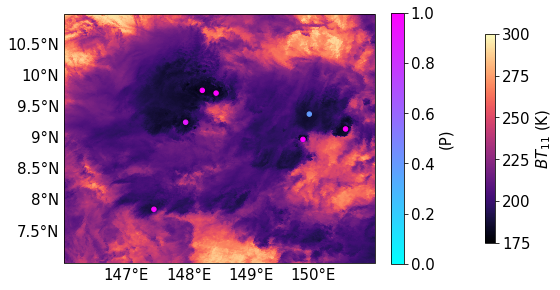

In [1]:
#this script is try to get the polygon area
def read_text(fname):
    fo=open(fname,'r') #create file object
    #headstr=fo.readline()
    data=fo.readlines()
    #print (data)
    fo.close()  # close object
    return data

from skimage.measure import label, regionprops

import numpy as np

import glob
import sys
import xarray as xr
import numpy as np
import cartopy
import scipy
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.colors import ListedColormap
from scipy.ndimage import gaussian_filter
import pandas as pd
import glob
from IPython.core.debugger import set_trace
from shapely.geometry import Polygon
import shapely
from cartopy.geodesic import Geodesic
import matplotlib.pyplot as plt
import pandas as pd
from pyhdf.SD import SD, SDC
import pandas as pd
import geopandas as gpd
309#import geopy.distance

mod02fname=glob.glob('/data/keeling/a/yulanh/satellite/TerraDataArchive/MODIS/MOD021KM/2019/309/MOD021KM.A2019309.0050*')
mod03fname=glob.glob('/data/keeling/a/yulanh/satellite/TerraDataArchive/MODIS/MOD03/2019/309/MOD03.A2019309.0050*')
mod02fname=mod02fname[0]
mod03fname=mod03fname[0]
OT_fname = '/data/keeling/a/yulanh/c/OT_output/Terra/2019/MODIS_OTinfo_2019309.0050.txt'
GPM_fname='/data/accp/a/snesbitt/gpmdata/radar/2019/11/2A.GPM.DPR.V8-20180723.20191105-S000639-E013912.032301.V06A.HDF5'
merra2_fname='/data/keeling/a/yulanh/c/MERRA-2/2019/MERRA2_400.inst1_2d_asm_Nx.20191105.nc4'
hour_scp=0
winsize=(7,7)
lat=[7,11]
lon=[146,151]
shrink=0.5
pad=0.1
fontsz=15
planck_c1=1.191042e8
planck_c2=1.4387752e4

hdf=SD(mod03fname,SDC.READ)
mod_lat=hdf.select('Latitude')[:]
mod_lon=hdf.select('Longitude')[:]

hdf=SD(mod02fname,SDC.READ)
sds_250=hdf.select('EV_250_Aggr1km_RefSB')
data_250=sds_250.get()
sds_250_att=sds_250.attributes()
for key, value in sds_250_att.items():
    if key == 'reflectance_scales':
        scale_250=np.asarray(value)
    if key == 'reflectance_offsets':
        offset_250=np.asarray(value)
        
sds_500=hdf.select('EV_500_Aggr1km_RefSB')
data_500=sds_500.get()
sds_500_att=sds_500.attributes()
for key, value in sds_500_att.items():
    if key == 'reflectance_scales':
        scale_500=np.asarray(value)
    if key == 'reflectance_offsets':
        offset_500=np.asarray(value)

data_shape=data_500.shape
along_track=data_shape[1]
cross_track=data_shape[2]


data=( data_250[0,:,:] - offset_250[0] ) * scale_250[0] 


#fig.savefig(save_title+'reflectance.jpg')

emis_obj=hdf.select('EV_1KM_Emissive')

for key, value in emis_obj.attributes().items():
    if key == 'radiance_offsets':
        add_offset = value  
    if key == 'radiance_scales':
        scale_factor = value
emis11=scale_factor[10]*(emis_obj[10,:,:]-add_offset[10])
bt11=planck_c2/(11.03*np.log(planck_c1/(emis11*11.03**5.0)+1))

emis67=scale_factor[6]*(emis_obj[6,:,:]-add_offset[6])
bt67=planck_c2/(6.72*np.log(planck_c1/(emis67*6.72**5.0)+1))
fig,ax = plt.subplots(figsize=winsize,subplot_kw={'projection': ccrs.PlateCarree()},constrained_layout=True)
img = ax.pcolormesh(mod_lon,mod_lat,bt11,vmin=175,vmax=300,cmap='magma')
ax.set_xlim(lon)
ax.set_ylim(lat)
gl=ax.gridlines(draw_labels=True,linestyle='None')
gl.xlabels_top=False
gl.ylabels_right=False
gl.xlines=False
gl.ylines=False
gl.xlabel_style={'size':fontsz,'color':'black'}
gl.ylabel_style={'size':fontsz,'color':'black'}
cb=plt.colorbar(img,shrink=shrink,pad=pad) 
cb.ax.tick_params(labelsize=fontsz)
cb.set_label(label='$BT_{11}$ (K)',size=fontsz)


OTdata=read_text(OT_fname)
splitcol=OTdata[0].split(' ')
Ncol=len(splitcol)-splitcol.count('')
Nrow=len(OTdata)
xscp=np.zeros(Nrow,'i')
yscp=np.zeros(Nrow,'i')
OTlon =np.zeros(Nrow,'f')
OTlat =np.zeros(Nrow,'f')
OTprob=np.zeros(Nrow,'f')
OTarea=np.zeros(Nrow,'f')
OTedge=np.zeros((Nrow,8),'i')
print(Nrow,Ncol)
# transfer data from string to float
dataT=np.zeros((Nrow,Ncol),'f')
for i in np.arange(Nrow):
    splitcol=OTdata[i].split(' ')
    k=0
    for j in range(len(splitcol)):
        if splitcol[j] != '' and splitcol[j] != '\n' : 
            dataT[i,k]=float(splitcol[j])
            k=k+1
            
    xscp[i]=dataT[i,0]
    yscp[i]=dataT[i,1]
    OTlon[i]=dataT[i,2]
    OTlat[i]=dataT[i,3]
    OTprob[i]=dataT[i,4]
    OTarea[i]=dataT[i,5]
    OTedge[i,:]=dataT[i,20:28]
    
    
p1=plt.scatter(OTlon,OTlat,s=20,c=OTprob,cmap=plt.get_cmap('cool'),vmin=0,vmax=1)
cb1=plt.colorbar(p1,shrink=0.60) 
cb1.ax.tick_params(labelsize=fontsz)
cb1.set_label(label='(P)',size=fontsz)

In [6]:
a=bt11[713-2:713+3,46-2:46+3]
b=pd.DataFrame(a)
print(b)

            0           1           2           3           4
0  194.289635  194.535318  194.289635  194.289635  194.289635
1  194.589715  194.097528  193.849201  193.571501  194.589715
2  194.508092  193.487821  192.698361  193.487821  194.508092
3  195.317162  193.821516  193.319941  193.821516  194.070010
4  198.554742  196.553944  195.609914  194.671178  194.179970


In [5]:
from pyproj import Geod
import geopy.distance
import pyproj    
import shapely
import shapely.ops as ops
from shapely.geometry.polygon import Polygon
from functools import partial

#print(OTlon)
#print(OTlat)
#print(xscp)
#print(yscp)
#print(OTlon[9],OTlat[9],OTarea[9],OTedge[9,:],np.mean(OTedge[9,:]))
winsize=4
bt11sm=gaussian_filter(bt11,sigma=1)
bt11_a=bt11sm[yscp[9]-winsize:yscp[9]+1+winsize,xscp[9]-winsize:xscp[9]+winsize+1]
modlat1=mod_lat[yscp[9]-winsize:yscp[9]+winsize+1,xscp[9]-winsize:xscp[9]+winsize+1]
modlon1=mod_lon[yscp[9]-winsize:yscp[9]+winsize+1,xscp[9]-winsize:xscp[9]+winsize+1]
df=pd.DataFrame(bt11_a)
#plt.imshow(bt11_a,cmap='magma')
x0=yscp[9]
y0=xscp[9]
#x0=713
#y0=46
hyp=winsize
num=winsize
#x1_all = [x0      , x0 + hyp, x0 + num, x0 + hyp, x0      , x0 - hyp, x0 - num, x0 - hyp]
#y1_all = [y0 + num, y0 + hyp, y0      , y0 - hyp, y0 - num, y0 - hyp, y0      , y0 + hyp]
# to match the fortran OT edge order
#x1_all = [x0 + num, x0 + num, x0    , x0 - num, x0 -num, x0 -num, x0    , x0 + num]
#y1_all = [y0      , y0 + num, y0+num, y0 + num, y0     , y0- num, y0-num, y0 -num]
#OTedge1=OTedge
#OTedge=OTedge[9,:]
x1_all = [x0 + OTedge[0], x0 + OTedge[1]*np.cos(45, dtype='f'), x0          , \
          x0 - OTedge[3]*np.cos(45, dtype='f'), x0 -OTedge[4]*np.cos(45, dtype='f'), \
          x0 -OTedge[5]*np.cos(45, dtype='f'), x0                               , \
          x0 + OTedge[7]*np.cos(45, dtype='f')]
y1_all = [y0            , y0 + OTedge[1]*np.cos(45, dtype='f'), y0+OTedge[2], \
          y0 + OTedge[3]*np.cos(45, dtype='f'), y0                                 , \
          y0 - OTedge[5]*np.cos(45, dtype='f'), y0-OTedge[6]*np.cos(45, dtype='f') , \
          y0 -OTedge[7]*np.cos(45, dtype='f')]
#== method 1===
#lats_bound= scipy.ndimage.map_coordinates(mod_lat, np.vstack((x1_all,y1_all)))
#lons_bound= scipy.ndimage.map_coordinates(mod_lon, np.vstack((x1_all,y1_all)))
#area, perim = geod.polygon_area_perimeter(lons_bound, lats_bound)
#tpOTA_poly=np.abs(area)/1000000.0

#== method 2===


In [6]:
print(x1_all)
print(y1_all)

[304, 301.5759660601616, 300, 298.4240339398384, 295.7974238395691, 297.89871191978455, 300, 304.7278981804848]
[910, 911.5759660601616, 916, 911.5759660601616, 910, 907.8987119197845, 908.4240339398384, 905.2721018195152]


In [9]:
#method 1
# Modules:
from pyproj import Geod
import numpy as np

# Define WGS84 as CRS:
geod = Geod('+a=6378137 +f=0.0033528106647475126')

# Data for Colorado (no need to close the polygon):
lats_bound= scipy.ndimage.map_coordinates(mod_lat, np.vstack((x1_all,y1_all)))
lons_bound= scipy.ndimage.map_coordinates(mod_lon, np.vstack((x1_all,y1_all)))
# Compute:
area, perim = geod.polygon_area_perimeter(lons_bound, lats_bound)
print(lons_bound)
print(lats_bound)
print(abs(area)/1000000.)  # Positive is counterclockwise, the data is clockwise.

[148.43843 148.4583  148.50609 148.46881 148.45598 148.4313  148.42813
 148.389  ]
[9.681852 9.702258 9.710453 9.725777 9.753807 9.737281 9.722299 9.682401]
39.247024412398936


In [15]:
# method 2
print(list(zip(x1_all,y1_all)))
a=Polygon(list(zip(x1_all,y1_all))).area
print(a)


[(304, 910), (301.5759660601616, 911.5759660601616), (300, 916), (298.4240339398384, 911.5759660601616), (295.7974238395691, 910), (297.89871191978455, 907.8987119197845), (300, 908.4240339398384), (304.7278981804848, 905.2721018195152)]
35.17177801805218


In [26]:
from pyproj import Transformer, transform, CRS
from shapely.geometry import Polygon
import shapely.ops as ops

geom =Polygon(zip(lons_bound, lats_bound))

crs_4326 = CRS.from_epsg(4326)

transformer = Transformer.from_crs(
    crs_4326,
    CRS(proj='aea', 
        lat_1=geom.bounds[1],
        lat_2=geom.bounds[3]
    )
)

geom_area = ops.transform(transformer.transform, geom)
print(geom_area)

POLYGON ((inf inf, inf inf, inf inf, inf inf, inf inf, inf inf, inf inf, inf inf, inf inf))


In [23]:
# method 3
import pyproj
from shapely.geometry import shape
from shapely.ops import transform

polygon_geom=Polygon(zip(lons_bound, lats_bound))
print(polygon_geom)
geom = {'type': 'Polygon',
'coordinates': zip(lons_bound,lats_bound)}
print([[lons_bound],[lats_bound]])
s = shape(geom)
wgs84 = pyproj.CRS('EPSG:4326')
utm = pyproj.CRS('EPSG:3857')
project = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True).transform
projected_area = transform(project, s).area
print(projected_area )
print(polygon_geom)

POLYGON ((148.4384307861328 9.681852340698242, 148.4582977294922 9.702258110046387, 148.5060882568359 9.710453033447266, 148.4688110351562 9.725776672363281, 148.4559783935547 9.753807067871094, 148.4313049316406 9.73728084564209, 148.4281311035156 9.722298622131348, 148.3890075683594 9.682400703430176, 148.4384307861328 9.681852340698242))
[[array([148.43843, 148.4583 , 148.50609, 148.46881, 148.45598, 148.4313 ,
       148.42813, 148.389  ], dtype=float32)], [array([9.681852, 9.702258, 9.710453, 9.725777, 9.753807, 9.737281,
       9.722299, 9.682401], dtype=float32)]]


TypeError: 'zip' object is not subscriptable

In [28]:
from area import area

obj = {'type':'Polygon','coordinates':[[[lons_bound[0],lats_bound[0]],\
                                        [lons_bound[1],lats_bound[1]],\
                                        [lons_bound[2],lats_bound[2]],\
                                        [lons_bound[3],lats_bound[3]],\
                                        [lons_bound[4],lats_bound[4]],\
                                        [lons_bound[5],lats_bound[5]],\
                                        [lons_bound[6],lats_bound[6]],\
                                        [lons_bound[7],lats_bound[7]],\
                                       ]]}

area_m2 = area(obj)

area_km2 = area_m2 / 1e+6

ModuleNotFoundError: No module named 'area'